In [1]:
import numpy as np
import pandas as pd
import os
import librosa.display
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from scipy.stats import spearmanr as corr

Step 1: Plot mel spectograms of two pieces with different genres.

In [2]:
# load spectograms

# genre: classical
spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/23160.fused.full.npy')  # fused spectrogram + chromagram
mel1, chroma1 = spec1[:128], spec1[128:]  # decompose into the mel spectrogram and chromagram

# genre: metal
spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/44278.fused.full.npy')
mel2, chroma2 = spec2[:128], spec2[128:]

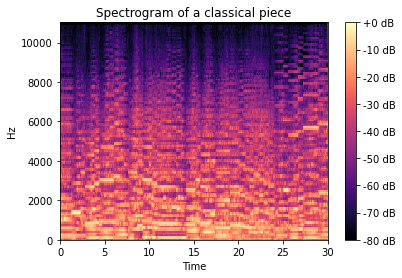

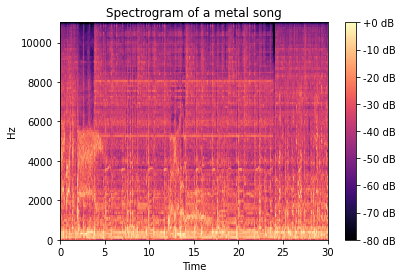

In [3]:
# plot mel spectograms

# classical
fig, ax = plt.subplots()
img = librosa.display.specshow(mel1, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram of a classical piece')
fig.colorbar(img, ax=ax, format="%+2.f dB")

# metal
fig, ax = plt.subplots()
img = librosa.display.specshow(mel2, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectrogram of a metal song')
fig.colorbar(img, ax=ax, format="%+2.f dB")



Step 2: Plot beat-synced spectrograms

In [4]:
# print dimension of previous spectograms
print(mel1.shape) 
print(mel2.shape) 

# load beat-synced spectograms

# genre: classical
bs_spec1 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/23160.fused.full.npy')
bs_mel1, bs_chroma1 = bs_spec1[:128], bs_spec1[128:]

# genre: metal
bs_spec2 = np.load('/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/44278.fused.full.npy')
bs_mel2, bs_chroma2 = bs_spec2[:128], bs_spec2[128:]

# print dimension of beat-synced spectograms
print(bs_mel1.shape) 
print(bs_mel2.shape) 


(128, 1293)
(128, 1293)
(128, 56)
(128, 48)


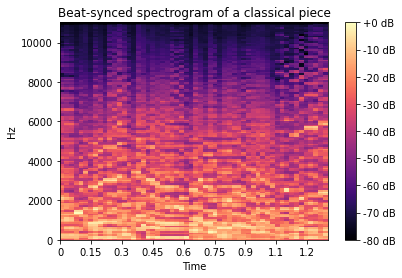

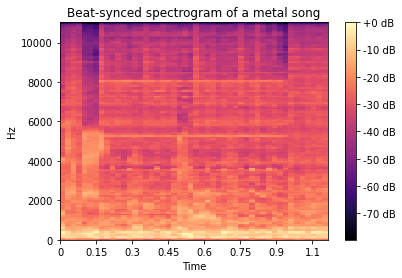

In [5]:
# plot beat-synced spectograms

# classical
fig, ax = plt.subplots()
img = librosa.display.specshow(bs_mel1, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Beat-synced spectrogram of a classical piece')
fig.colorbar(img, ax=ax, format="%+2.f dB")

# metal
fig, ax = plt.subplots()
img = librosa.display.specshow(bs_mel2, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Beat-synced spectrogram of a metal song')
fig.colorbar(img, ax=ax, format="%+2.f dB")

Step 3: Plot chromagrams

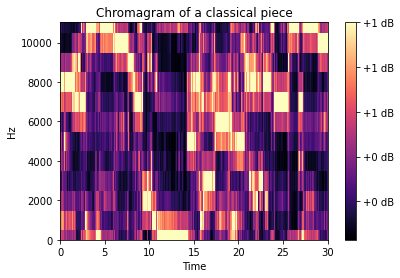

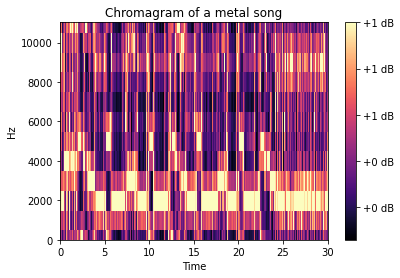

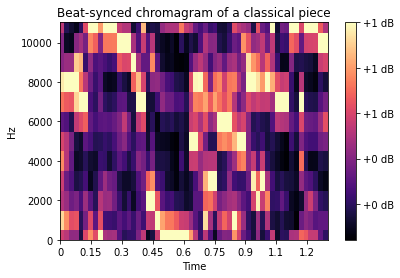

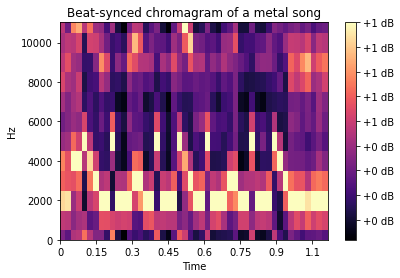

In [6]:
# plot chromagrams

# classical
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma1, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Chromagram of a classical piece')
fig.colorbar(img, ax=ax, format="%+2.f dB")

# metal
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma2, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Chromagram of a metal song')
fig.colorbar(img, ax=ax, format="%+2.f dB")

# plot beat-synced chromagrams

# classical
fig, ax = plt.subplots()
img = librosa.display.specshow(bs_chroma1, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Beat-synced chromagram of a classical piece')
fig.colorbar(img, ax=ax, format="%+2.f dB")

# metal
fig, ax = plt.subplots()
img = librosa.display.specshow(bs_chroma2, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Beat-synced chromagram of a metal song')
fig.colorbar(img, ax=ax, format="%+2.f dB")

Step 4: Load and analyze data

In [7]:
# Combine similar classes and remove underrepresented classes
class_mapping = {
    'Rock': 'Rock',
    'Psych-Rock': 'Rock',
    'Indie-Rock': None,
    'Post-Rock': 'Rock',
    'Psych-Folk': 'Folk',
    'Folk': 'Folk',
    'Metal': 'Metal',
    'Punk': 'Metal',
    'Post-Punk': None,
    'Trip-Hop': 'Trip-Hop',
    'Pop': 'Pop',
    'Electronic': 'Electronic',
    'Hip-Hop': 'Hip-Hop',
    'Classical': 'Classical',
    'Blues': 'Blues',
    'Chiptune': 'Electronic',
    'Jazz': 'Jazz',
    'Soundtrack': None,
    'International': None,
    'Old-Time': None
}


# Helper functions to read fused, mel, and chromagram
def read_fused_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)
    return spectrogram.T


def read_mel_spectrogram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[:128]
    return spectrogram.T

    
def read_chromagram(spectrogram_file):
    spectrogram = np.load(spectrogram_file)[128:]
    return spectrogram.T


def torch_train_val_split(
        dataset, batch_train, batch_eval,
        val_size=.2, shuffle=True, seed=None):
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    val_split = int(np.floor(val_size * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices = indices[val_split:]
    val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset,
                              batch_size=batch_train,
                              sampler=train_sampler)
    val_loader = DataLoader(dataset,
                            batch_size=batch_eval,
                            sampler=val_sampler)
    return train_loader, val_loader


class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])
        

class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[:self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1
        
        
# Pytorch Dataset Class for creating the dataset
class SpectrogramDataset(Dataset):
    def __init__(self, path, class_mapping=None, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(self.label_transformer.fit_transform(labels)).astype('int64')

    def get_files_labels(self, txt, class_mapping):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    def __getitem__(self, item):
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)

In [8]:
# Create a pytorch dataset for mel spectrograms (not beat-synced)

mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
    
train_loader_mel, val_loader_mel = torch_train_val_split(mel_specs, 32 ,32, val_size=.33)
     
test_loader_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_mel = DataLoader(test_loader_mel, batch_size=32)

# Lets see an example sample from the dataset

datum = next(iter(train_loader_mel))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

Data shape
torch.Size([32, 1293, 128])
Labels
tensor([3, 2, 2, 4, 2, 7, 8, 2, 6, 7, 8, 9, 8, 2, 4, 0, 6, 8, 6, 5, 3, 7, 9, 4,
        2, 4, 9, 8, 1, 6, 5, 9])
Lengths
tensor([1291, 1293, 1291, 1293, 1291, 1291, 1291, 1292, 1291, 1291, 1293, 1291,
        1293, 1291, 1291, 1293, 1291, 1291, 1292, 1293, 1291, 1293, 1293, 1293,
        1293, 1291, 1293, 1293, 1291, 1291, 1293, 1291])


In [9]:
# Create a pytorch dataset for beat synced mel spectrograms

beat_mel_specs = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
    
train_loader_beat_mel, val_loader_beat_mel = torch_train_val_split(beat_mel_specs, 32 ,32, val_size=.33)
     
test_loader_beat_mel = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_mel_spectrogram)
test_loader_beat_mel = DataLoader(test_loader_beat_mel, batch_size=32)

# Lets see an example sample from the dataset

datum = next(iter(train_loader_beat_mel))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

Data shape
torch.Size([32, 129, 128])
Labels
tensor([4, 4, 8, 3, 2, 8, 1, 9, 0, 8, 0, 3, 5, 2, 3, 8, 2, 2, 8, 9, 4, 8, 1, 2,
        2, 9, 6, 4, 7, 0, 1, 2])
Lengths
tensor([76, 51, 94, 81, 54, 53, 72, 47, 59, 44, 74, 60, 60, 92, 55, 41, 48, 71,
        56, 38, 81, 53, 61, 56, 57, 65, 38, 76, 61, 71, 52, 74])


In [10]:
# Create a pytorch dataset for beat synced chromagrams

beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)

train_loader_beat_chroma, val_loader_beat_chroma = torch_train_val_split(beat_chroma, 32 ,32, val_size=.33)

test_loader_beat_chroma = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=False,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_chromagram)
test_loader_beat_chroma = DataLoader(test_loader_beat_chroma, batch_size=32)

# Lets see an example sample from the beat chroma dataset

datum = next(iter(train_loader_beat_chroma))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

Data shape
torch.Size([32, 129, 12])
Labels
tensor([7, 1, 3, 8, 7, 1, 4, 6, 2, 8, 8, 8, 0, 9, 2, 2, 7, 2, 3, 0, 6, 3, 6, 3,
        9, 8, 8, 0, 6, 2, 6, 4])
Lengths
tensor([62, 56, 71, 53, 62, 63, 41, 54, 65, 43, 71, 57, 47, 45, 50, 59, 73, 63,
        56, 39, 48, 54, 61, 48, 84, 66, 50, 58, 71, 75, 50, 50])


In [11]:
# Create a pytorch dataset for the fused spectrogram + chromagram beat-synced data

specs_fused = SpectrogramDataset(
         '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
         train=True,
         class_mapping=class_mapping,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)

train_loader, val_loader = torch_train_val_split(specs_fused, 32 ,32, val_size=.33)

test_loader = SpectrogramDataset(
     '../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/',
     train=False,
     class_mapping=class_mapping,
     max_length=-1,
     read_spec_fn=read_fused_spectrogram)
test_loader = DataLoader(test_loader, batch_size=32)

datum = next(iter(train_loader))
print('Data shape')
print(datum[0].shape)  # shape of data
print('Labels')
print(datum[1])  # labels in batch
print('Lengths')
print(datum[2])  # length of each element in batch

Data shape
torch.Size([32, 129, 140])
Labels
tensor([8, 7, 5, 8, 4, 8, 8, 6, 2, 6, 1, 9, 1, 8, 6, 8, 7, 3, 8, 6, 7, 1, 6, 8,
        5, 5, 1, 3, 4, 2, 9, 1])
Lengths
tensor([84, 66, 42, 65, 52, 77, 65, 58, 50, 59, 42, 87, 79, 42, 75, 60, 56, 56,
        29, 54, 70, 86, 77, 69, 64, 63, 73, 30, 45, 61, 79, 52])


[Text(0.5, 1.0, 'Samples per class after reduction')]

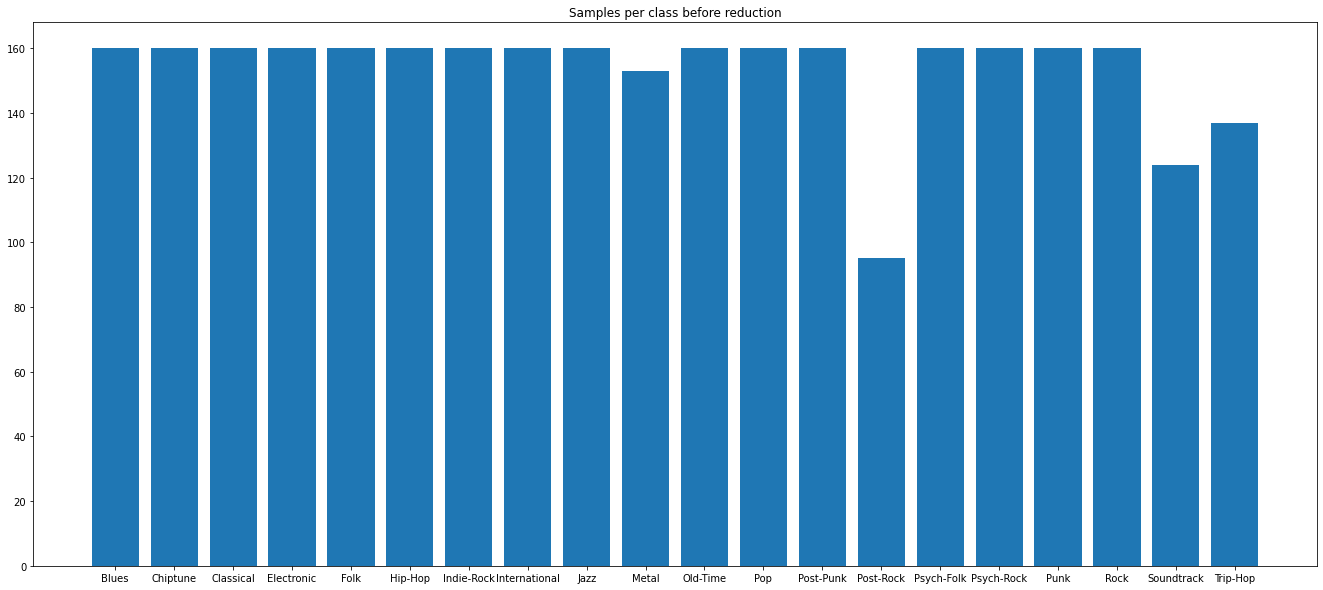

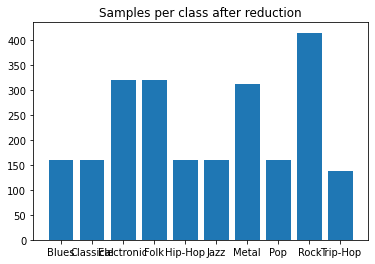

In [12]:
# load labels
def get_files_labels(txt, class_mapping):
    with open(txt, 'r') as fd:
        lines = [l.rstrip().split('\t') for l in fd.readlines()[1:]]
    files, labels = [], []
    for l in lines:
        label = l[1]
        if class_mapping:
            label = class_mapping[l[1]]
        if not label:
            continue
        # Kaggle automatically unzips the npy.gz format so this hack is needed
        _id = l[0].split('.')[0]
        npy_file = '{}.fused.full.npy'.format(_id)
        files.append(npy_file)
        labels.append(label)
    return files, labels

path = os.path.join('../input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/', "{}_labels.txt".format('train'))

# print class histogram before mapping
_, labels = get_files_labels(path, None)
classes, counts = np.unique(labels, return_counts = True)
fig, ax = plt.subplots(figsize=(23, 10))
ax.bar(classes, counts)
ax.set(title='Samples per class before reduction')


# print class histogram after mapping
_, labels = get_files_labels(path, class_mapping)
classes, counts = np.unique(labels, return_counts = True)
fig, ax = plt.subplots()
ax.bar(classes, counts)
ax.set(title='Samples per class after reduction')


Step 5: Genre Classification with Long Short-Term Memory (LSTM) Network

In [13]:
# The LSTM network

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers, bidirectional=False):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # Initialize the LSTM, Dropout, Output layers
        self.lstm = nn.LSTM(input_dim, rnn_size, num_layers, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(rnn_size, output_dim)

    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index

            lengths: N x 1
         """
        x, _ = self.lstm(x)
        x = self.last_timestep(x, lengths, self.bidirectional)
        x = self.fc(x)
        return x

    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx.long()).squeeze()

In [14]:
# Train lstm with specified train/val loaders and save it using specified checkpoint_name
def train_lstm(train_dl, val_dl, checkpoint_name):
    
    # hyper parameters
    RNN_SIZE = 128
    NUM_LAYERS = 2
    BIDIRECTIONAL = True
    L2 = 0.001
    EPOCHS = 200  # max epochs
    PATIENCE = 5  # for early stopping
    
    # initialize model    
    model = BasicLSTM(input_dim=next(iter(train_dl))[0].shape[2], rnn_size=RNN_SIZE, output_dim=10, num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=L2)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)

    avg_train_losses = []  # track train loss in each epoch
    avg_val_losses = []  # track validation loss in each epoch
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # train model
    model.train()
    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        for i, data in enumerate(train_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            optimizer.zero_grad()
            out = model(X_batch.float(), lengths)
            loss = criterion(out, y_batch.long())
            loss.backward()
            optimizer.step()
            # track loss
            train_losses.append(loss.detach().item())
        avg_train_loss = np.average(train_losses)
        avg_train_losses.append(avg_train_loss)

        # calculate validation loss and accuracy
        val_predictions = []
        y_val = []
        with torch.no_grad():
            for i, data in enumerate(val_dl):
                X_batch, y_batch, lengths = data
                X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
                out = model(X_batch.float(), lengths)
                loss = criterion(out, y_batch.long())  # loss
                val_losses.append(loss.detach().item())
                val, y_pred = out.max(1)  # predictions
                val_predictions.extend(y_pred.detach().cpu().numpy())
                y_val.extend(y_batch.tolist())
        avg_val_loss = np.average(val_losses)
        avg_val_losses.append(avg_val_loss)
        vall_acc = np.mean(np.array(y_val) == np.array(val_predictions))

        # print information
        print("Epoch: {}  -  loss: {}  -  val_loss: {}  - val_acc: {}".format(epoch, avg_train_loss, avg_val_loss, vall_acc))

        # early stopping
        if avg_val_loss < min_val_loss:
            torch.save(model, checkpoint_name)  # save checkpoint
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
        else:
            epochs_no_improve += 1
        if epoch > PATIENCE and epochs_no_improve == PATIENCE:
            print('Early stopping')
            break

In [15]:
def evaluate_lstm(test_dl, checkpoint_name):
    # load best model
    model = torch.load(checkpoint_name)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    
    # predict test
    model.eval()
    test_predictions = []
    y_test = []
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            out = model(X_batch.float(), lengths)
            val, y_pred = out.max(1)
            test_predictions.extend(y_pred.detach().cpu().numpy())
            y_test.extend(y_batch.tolist())

    print("Classification report:")
    print(classification_report(np.array(y_test), np.array(test_predictions)))

Train models

In [16]:
# train lstm with mel spectograms
train_lstm(train_loader_mel, val_loader_mel, 'lstm_mel.th')

Epoch: 1  -  loss: 2.266617570604597  -  val_loss: 2.2372564375400543  - val_acc: 0.15394736842105264
Epoch: 2  -  loss: 2.224818283197831  -  val_loss: 2.195826997359594  - val_acc: 0.175
Epoch: 3  -  loss: 2.1772045943201803  -  val_loss: 2.131060928106308  - val_acc: 0.21973684210526315
Epoch: 4  -  loss: 2.1163601072467104  -  val_loss: 2.0955355366071067  - val_acc: 0.2394736842105263
Epoch: 5  -  loss: 2.100767916562606  -  val_loss: 2.086747422814369  - val_acc: 0.26710526315789473
Epoch: 6  -  loss: 2.1323591543703664  -  val_loss: 2.336900552113851  - val_acc: 0.13421052631578947
Epoch: 7  -  loss: 2.274041292618732  -  val_loss: 2.1914433936278024  - val_acc: 0.21052631578947367
Epoch: 8  -  loss: 2.1783841775388133  -  val_loss: 2.112527072429657  - val_acc: 0.275
Epoch: 9  -  loss: 2.12814390416048  -  val_loss: 2.1487435748179755  - val_acc: 0.2118421052631579
Epoch: 10  -  loss: 2.1177755886194656  -  val_loss: 2.0561231772104898  - val_acc: 0.2578947368421053
Epoch: 11  

In [17]:
# train lstm with beat-synced spectograms
train_lstm(train_loader_beat_mel, val_loader_beat_mel, 'lstm_beat_mel.th')

Epoch: 1  -  loss: 2.278983383762593  -  val_loss: 2.2477572560310364  - val_acc: 0.20394736842105263
Epoch: 2  -  loss: 2.2332974939930197  -  val_loss: 2.21237713098526  - val_acc: 0.18552631578947368
Epoch: 3  -  loss: 2.2045585963190817  -  val_loss: 2.1850243906180062  - val_acc: 0.1986842105263158
Epoch: 4  -  loss: 2.1652048266663844  -  val_loss: 2.133989234765371  - val_acc: 0.26973684210526316
Epoch: 5  -  loss: 2.0922058577440223  -  val_loss: 2.0666667272647223  - val_acc: 0.26052631578947366
Epoch: 6  -  loss: 2.026890815520773  -  val_loss: 2.0727049062649407  - val_acc: 0.26973684210526316
Epoch: 7  -  loss: 2.1326893908636912  -  val_loss: 2.0135044107834497  - val_acc: 0.2855263157894737
Epoch: 8  -  loss: 1.9789218245720377  -  val_loss: 1.9805229157209396  - val_acc: 0.3026315789473684
Epoch: 9  -  loss: 1.9517798277796532  -  val_loss: 1.958518922328949  - val_acc: 0.3355263157894737
Epoch: 10  -  loss: 1.9160726411002023  -  val_loss: 1.9340446094671886  - val_acc:

In [18]:
# train lstm with beat-synced chromagrams
train_lstm(train_loader_beat_chroma, val_loader_beat_chroma, 'lstm_chroma.th')

Epoch: 1  -  loss: 2.2881076530534394  -  val_loss: 2.2831876377264657  - val_acc: 0.18289473684210528
Epoch: 2  -  loss: 2.2672112766577275  -  val_loss: 2.255685329437256  - val_acc: 0.18289473684210528
Epoch: 3  -  loss: 2.2237222535269603  -  val_loss: 2.2283226251602173  - val_acc: 0.18289473684210528
Epoch: 4  -  loss: 2.215988353807099  -  val_loss: 2.228031555811564  - val_acc: 0.18289473684210528
Epoch: 5  -  loss: 2.212901159208648  -  val_loss: 2.229177643855413  - val_acc: 0.18289473684210528
Epoch: 6  -  loss: 2.212036200932094  -  val_loss: 2.228726585706075  - val_acc: 0.18289473684210528
Epoch: 7  -  loss: 2.2125409233326816  -  val_loss: 2.224214047193527  - val_acc: 0.18289473684210528
Epoch: 8  -  loss: 2.207234504271527  -  val_loss: 2.224940220514933  - val_acc: 0.18289473684210528
Epoch: 9  -  loss: 2.2044883066294143  -  val_loss: 2.2252586086591086  - val_acc: 0.18289473684210528
Epoch: 10  -  loss: 2.205782598378707  -  val_loss: 2.2214368085066476  - val_acc: 

In [19]:
# train lstm with fused data
train_lstm(train_loader, val_loader, 'lstm_fused.th')


Epoch: 1  -  loss: 2.243052881591174  -  val_loss: 2.2187162737051644  - val_acc: 0.18157894736842106
Epoch: 2  -  loss: 2.1935881692536023  -  val_loss: 2.1844106912612915  - val_acc: 0.22894736842105262
Epoch: 3  -  loss: 2.1365010884343363  -  val_loss: 2.1005681455135345  - val_acc: 0.24078947368421053
Epoch: 4  -  loss: 2.077578367019186  -  val_loss: 2.050853615005811  - val_acc: 0.2644736842105263
Epoch: 5  -  loss: 2.0348096429085243  -  val_loss: 2.0807450264692307  - val_acc: 0.2513157894736842
Epoch: 6  -  loss: 2.0410753853467045  -  val_loss: 2.0647134135166803  - val_acc: 0.2578947368421053
Epoch: 7  -  loss: 2.025714005742754  -  val_loss: 2.059690937399864  - val_acc: 0.24736842105263157
Epoch: 8  -  loss: 1.978608790709048  -  val_loss: 1.977262258529663  - val_acc: 0.2986842105263158
Epoch: 9  -  loss: 1.9448292523014301  -  val_loss: 1.9996282905340195  - val_acc: 0.2868421052631579
Epoch: 10  -  loss: 1.926197859705711  -  val_loss: 1.9622304141521454  - val_acc: 0.

Evaluate models

In [20]:
# evaluate lstm with mel spectograms
evaluate_lstm(test_loader_mel, 'lstm_mel.th')

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.64      0.17      0.27        40
           2       0.24      0.65      0.35        80
           3       0.22      0.66      0.33        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        78
           7       0.00      0.00      0.00        40
           8       0.26      0.26      0.26       103
           9       0.00      0.00      0.00        34

    accuracy                           0.24       575
   macro avg       0.14      0.17      0.12       575
weighted avg       0.16      0.24      0.16       575



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# train lstm with beat-synced spectograms
evaluate_lstm(test_loader_beat_mel, 'lstm_beat_mel.th')

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.36      0.60      0.45        40
           2       0.29      0.70      0.41        80
           3       0.34      0.53      0.41        80
           4       1.00      0.03      0.05        40
           5       0.00      0.00      0.00        40
           6       0.52      0.58      0.55        78
           7       0.00      0.00      0.00        40
           8       0.37      0.36      0.36       103
           9       0.00      0.00      0.00        34

    accuracy                           0.36       575
   macro avg       0.29      0.28      0.22       575
weighted avg       0.32      0.36      0.29       575



In [22]:
# train lstm with beat-synced chromagrams
evaluate_lstm(test_loader_beat_chroma, 'lstm_chroma.th')

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        80
           3       0.21      0.66      0.32        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.29      0.47      0.36        78
           7       0.00      0.00      0.00        40
           8       0.18      0.35      0.24       103
           9       0.00      0.00      0.00        34

    accuracy                           0.22       575
   macro avg       0.07      0.15      0.09       575
weighted avg       0.10      0.22      0.14       575



In [23]:
# train lstm with fused data
evaluate_lstm(test_loader, 'lstm_fused.th')

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.34      0.55      0.42        40
           2       0.30      0.75      0.43        80
           3       0.29      0.64      0.40        80
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        40
           6       0.51      0.58      0.54        78
           7       0.00      0.00      0.00        40
           8       0.32      0.16      0.21       103
           9       0.00      0.00      0.00        34

    accuracy                           0.34       575
   macro avg       0.18      0.27      0.20       575
weighted avg       0.23      0.34      0.26       575



Step 7: 2D CNN

In [24]:
# The CNN

# Convolution Block
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(ConvBlock, self).__init__()

      self.conv =  nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
      self.batch = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU()
      self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
      
  def forward(self, x):
      return self.pool(self.relu(self.batch(self.conv(x))))
      

class BasicCNN(nn.Module):
    def __init__(self, output_dim):
        super(BasicCNN, self).__init__()

        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=16),
            ConvBlock(in_channels=16, out_channels=32),
            ConvBlock(in_channels=32, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1920, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, x.size(1), x.size(2)) # reshape to have 1 channel
        x = self.conv(x)
        #print(x.size())
        return self.fc(x)

In [25]:
# Train CNN with specified train/val loaders and save it using specified checkpoint_name
def train_cnn(train_dl, val_dl, checkpoint_name):
    
    # hyper parameters
    L2 = 0.0001
    EPOCHS = 100  # max epochs
    PATIENCE = 5  # for early stopping
    
    # initialize model    
    model = BasicCNN(output_dim=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=L2)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)

    avg_train_losses = []  # track train loss in each epoch
    avg_val_losses = []  # track validation loss in each epoch
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # train model
    model.train()
    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        for i, data in enumerate(train_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            optimizer.zero_grad()
            out = model(X_batch.float())
            loss = criterion(out, y_batch.long())
            loss.backward()
            optimizer.step()
            # track loss
            train_losses.append(loss.detach().item())
        avg_train_loss = np.average(train_losses)
        avg_train_losses.append(avg_train_loss)

        # calculate validation loss and accuracy
        val_predictions = []
        y_val = []
        with torch.no_grad():
            for i, data in enumerate(val_dl):
                X_batch, y_batch, lengths = data
                X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
                out = model(X_batch.float())
                loss = criterion(out, y_batch.long())  # loss
                val_losses.append(loss.detach().item())
                val, y_pred = out.max(1)  # predictions
                val_predictions.extend(y_pred.detach().cpu().numpy())
                y_val.extend(y_batch.tolist())
        avg_val_loss = np.average(val_losses)
        avg_val_losses.append(avg_val_loss)
        vall_acc = np.mean(np.array(y_val) == np.array(val_predictions))

        # print information
        print("Epoch: {}  -  loss: {}  -  val_loss: {}  - val_acc: {}".format(epoch, avg_train_loss, avg_val_loss, vall_acc))

        # early stopping
        if avg_val_loss < min_val_loss:
            torch.save(model, checkpoint_name)  # save checkpoint
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
        else:
            epochs_no_improve += 1
        if epoch > PATIENCE and epochs_no_improve == PATIENCE:
            print('Early stopping')
            break

In [26]:
def evaluate_cnn(test_dl, checkpoint_name):
    # load best model
    model = torch.load(checkpoint_name)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    
    # predict test
    model.eval()
    test_predictions = []
    y_test = []
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            out = model(X_batch.float())
            val, y_pred = out.max(1)
            test_predictions.extend(y_pred.detach().cpu().numpy())
            y_test.extend(y_batch.tolist())

    print("Classification report:")
    print(classification_report(np.array(y_test), np.array(test_predictions)))

In [27]:
# train and evaluate cnn
train_cnn(train_loader_mel, val_loader_mel, 'cnn_mel.th')
evaluate_cnn(test_loader_mel, 'cnn_mel.th')

Epoch: 1  -  loss: 2.032968041848163  -  val_loss: 1.9278978357712429  - val_acc: 0.32763157894736844
Epoch: 2  -  loss: 1.74997320467112  -  val_loss: 1.8517278333504994  - val_acc: 0.35789473684210527
Epoch: 3  -  loss: 1.6549060758279295  -  val_loss: 1.7972579499085743  - val_acc: 0.3815789473684211
Epoch: 4  -  loss: 1.5551471053337564  -  val_loss: 1.746720274289449  - val_acc: 0.3973684210526316
Epoch: 5  -  loss: 1.4445369535562944  -  val_loss: 1.7636325856049855  - val_acc: 0.40921052631578947
Epoch: 6  -  loss: 1.369385921225256  -  val_loss: 1.7093199839194615  - val_acc: 0.4328947368421053
Epoch: 7  -  loss: 1.2633011511393957  -  val_loss: 1.6880917847156525  - val_acc: 0.41578947368421054
Epoch: 8  -  loss: 1.172411681437979  -  val_loss: 1.7197879999876022  - val_acc: 0.4368421052631579
Epoch: 9  -  loss: 1.0950997447480961  -  val_loss: 1.7015521774689357  - val_acc: 0.4355263157894737
Epoch: 10  -  loss: 1.0182296816183596  -  val_loss: 1.7203796009222667  - val_acc: 

Step 8: Emotion recognition

In [28]:
# Pytorch Dataset Class for creating the dataset
class SpectrogramDatasetEmotion(Dataset):
    def __init__(self, path, target, train=True, max_length=-1, read_spec_fn=read_fused_spectrogram):
        t = 'train' if train else 'test'
        p = os.path.join(path, t)
        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, target)
        self.feats = [read_spec_fn(os.path.join(p, f)) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(np.array(labels).astype('float')).reshape(-1, 1)

    def get_files_labels(self, txt, target):
        with open(txt, 'r') as fd:
            lines = [l.rstrip().split(',') for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            if target=='valence':
                label = l[1]
            elif target=='energy':
                label = l[2]
            elif target=='danceability':
                label = l[3]
            else:
                label = [l[1], l[2], l[3]]
            # Kaggle automatically unzips the npy.gz format so this hack is needed
            _id = l[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            files.append(npy_file)
            labels.append(label)
        return files, labels
    
    def __getitem__(self, item):
        l = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], l

    def __len__(self):
        return len(self.labels)

LSTM

In [29]:
# Create pytorch datasets for beat-synced mel spectrograms

# load valence dataset
specs_valence_beat = SpectrogramDatasetEmotion(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset_beat/',
         target='valence',
         train=True,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
    
train_loader_valence_beat, val_loader_valence_beat = torch_train_val_split(specs_valence_beat, 32 ,32)

# load energy dataset
specs_energy_beat = SpectrogramDatasetEmotion(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset_beat/',
         target='energy',
         train=True,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
    
train_loader_energy_beat, val_loader_energy_beat = torch_train_val_split(specs_energy_beat, 32 ,32)

# load danceability dataset
specs_danceability_beat = SpectrogramDatasetEmotion(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset_beat/',
         target='danceability',
         train=True,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
    
train_loader_danceability_beat, val_loader_danceability_beat = torch_train_val_split(specs_danceability_beat, 32 ,32)



In [30]:
# Train lstm with specified train/val loaders and save it using specified checkpoint_name
def train_lstm(train_dl, val_dl, checkpoint_name):
    
    # hyper parameters
    RNN_SIZE = 128
    NUM_LAYERS = 2
    BIDIRECTIONAL = True
    L2 = 0.001
    EPOCHS = 200  # max epochs
    PATIENCE = 10  # for early stopping
    
    # initialize model    
    model = BasicLSTM(input_dim=next(iter(train_dl))[0].shape[2], rnn_size=RNN_SIZE, output_dim=1, num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=L2)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)

    avg_train_losses = []  # track train loss in each epoch
    avg_val_losses = []  # track validation loss in each epoch
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # train model
    model.train()
    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        for i, data in enumerate(train_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            optimizer.zero_grad()
            out = model(X_batch.float(), lengths)
            loss = criterion(out, y_batch.float())
            loss.backward()
            optimizer.step()
            # track loss
            train_losses.append(loss.detach().item())
        avg_train_loss = np.average(train_losses)
        avg_train_losses.append(avg_train_loss)

        # calculate validation loss and accuracy
        with torch.no_grad():
            for i, data in enumerate(val_dl):
                X_batch, y_batch, lengths = data
                X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
                out = model(X_batch.float(), lengths)
                loss = criterion(out, y_batch.float())  # loss
                val_losses.append(loss.detach().item())
        avg_val_loss = np.average(val_losses)
        avg_val_losses.append(avg_val_loss)

        # print information
        print("Epoch: {}  -  loss: {}  -  val_loss: {}".format(epoch, avg_train_loss, avg_val_loss))

        # early stopping
        if avg_val_loss < min_val_loss:
            torch.save(model, checkpoint_name)  # save checkpoint
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
        else:
            epochs_no_improve += 1
        if epoch > PATIENCE and epochs_no_improve == PATIENCE:
            print('Early stopping')
            break

In [31]:
def evaluate_lstm(test_dl, checkpoint_name):
    # load best model
    model = torch.load(checkpoint_name)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    
    # predict test
    model.eval()
    test_predictions = []
    y_test = []
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            out = model(X_batch.float(), lengths)
            test_predictions.extend(out.detach().cpu().numpy())
            y_test.extend(y_batch.tolist())
            
    correlation = corr(np.array(y_test), np.array(test_predictions)).correlation
    print('Correlation =', correlation)

    return correlation

In [32]:
# train lstm for valence
train_lstm(train_loader_valence_beat, val_loader_valence_beat, 'lstm_valence.th')

Epoch: 1  -  loss: 0.17476346600672293  -  val_loss: 0.0643594813133989
Epoch: 2  -  loss: 0.06699820813433878  -  val_loss: 0.06448765737669808
Epoch: 3  -  loss: 0.06634668851720876  -  val_loss: 0.06376997966851507
Epoch: 4  -  loss: 0.0659710019826889  -  val_loss: 0.06313102532710348
Epoch: 5  -  loss: 0.06349091890171685  -  val_loss: 0.06435493539486613
Epoch: 6  -  loss: 0.06358945281405387  -  val_loss: 0.06196932228548186
Epoch: 7  -  loss: 0.06632603859079295  -  val_loss: 0.06175658160022327
Epoch: 8  -  loss: 0.06359221143969174  -  val_loss: 0.061454458960465023
Epoch: 9  -  loss: 0.06575576986732154  -  val_loss: 0.06174435040780476
Epoch: 10  -  loss: 0.06285251869723715  -  val_loss: 0.06226670795253345
Epoch: 11  -  loss: 0.0636391456656415  -  val_loss: 0.05978985716189657
Epoch: 12  -  loss: 0.06259201955178688  -  val_loss: 0.06476700518812452
Epoch: 13  -  loss: 0.06368114323965435  -  val_loss: 0.06314622504370553
Epoch: 14  -  loss: 0.06475631057702262  -  val_l

In [33]:
# train lstm for energy
train_lstm(train_loader_energy_beat, val_loader_energy_beat, 'lstm_energy.th')

Epoch: 1  -  loss: 0.26642542852666873  -  val_loss: 0.07666827525411334
Epoch: 2  -  loss: 0.06419399441701584  -  val_loss: 0.05947871506214142
Epoch: 3  -  loss: 0.06164511241789522  -  val_loss: 0.05587884464434215
Epoch: 4  -  loss: 0.0539522976453962  -  val_loss: 0.052265028336218426
Epoch: 5  -  loss: 0.05093145614554142  -  val_loss: 0.05090549801077161
Epoch: 6  -  loss: 0.05125630621252389  -  val_loss: 0.047921303127493174
Epoch: 7  -  loss: 0.048347756523510504  -  val_loss: 0.04594856660280909
Epoch: 8  -  loss: 0.04474175708561108  -  val_loss: 0.04401745966502598
Epoch: 9  -  loss: 0.04509286736619884  -  val_loss: 0.044641640569482534
Epoch: 10  -  loss: 0.04086100078862289  -  val_loss: 0.046295015939644406
Epoch: 11  -  loss: 0.04312495251410994  -  val_loss: 0.044747590486492426
Epoch: 12  -  loss: 0.04265589588161173  -  val_loss: 0.045123470414962084
Epoch: 13  -  loss: 0.04116059428658979  -  val_loss: 0.04369146323629788
Epoch: 14  -  loss: 0.04151062217765841  

In [34]:
# train lstm for danceability
train_lstm(train_loader_danceability_beat, val_loader_danceability_beat, 'lstm_danceability.th')

Epoch: 1  -  loss: 0.141560780077145  -  val_loss: 0.029065251084310666
Epoch: 2  -  loss: 0.0318734667400412  -  val_loss: 0.02900297354374613
Epoch: 3  -  loss: 0.03221523434180638  -  val_loss: 0.027634145958083018
Epoch: 4  -  loss: 0.03022885598756116  -  val_loss: 0.025822255228246962
Epoch: 5  -  loss: 0.029792486336724513  -  val_loss: 0.025356406612055644
Epoch: 6  -  loss: 0.02994733721274754  -  val_loss: 0.024374248992119516
Epoch: 7  -  loss: 0.028829166601444113  -  val_loss: 0.024914033178772246
Epoch: 8  -  loss: 0.028537886088778233  -  val_loss: 0.023566442940916334
Epoch: 9  -  loss: 0.027137690255868024  -  val_loss: 0.022291543228285655
Epoch: 10  -  loss: 0.027873939095899976  -  val_loss: 0.023564861555184637
Epoch: 11  -  loss: 0.027446668530846464  -  val_loss: 0.02272424554186208
Epoch: 12  -  loss: 0.026544921421285332  -  val_loss: 0.02265103587082454
Epoch: 13  -  loss: 0.02604326275016727  -  val_loss: 0.02429466801030295
Epoch: 14  -  loss: 0.027121119650

In [35]:
# evaluate lstm for valence
valence_corr = evaluate_lstm(val_loader_valence_beat, 'lstm_valence.th')

Correlation = 0.19215593531701228


In [36]:
# evaluate lstm for energy
energy_corr = evaluate_lstm(val_loader_energy_beat, 'lstm_energy.th')

Correlation = 0.6562492910026132


In [37]:
# evaluate lstm for danceability
danceability_corr = evaluate_lstm(val_loader_danceability_beat, 'lstm_danceability.th')

Correlation = 0.5832778127040271


In [38]:
# calculate mean correlation
print('Mean spearman correlation =', (valence_corr + energy_corr + danceability_corr) / 3)

Mean spearman correlation = 0.4772276796745509


CNN

In [39]:
# Create pytorch datasets for mel spectrograms (not beat-synced)
# load valence dataset
specs_valence = SpectrogramDatasetEmotion(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset/',
         target='valence',
         train=True,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
    
train_loader_valence, val_loader_valence = torch_train_val_split(specs_valence, 32 ,32)

# load energy dataset
specs_energy = SpectrogramDatasetEmotion(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset/',
         target='energy',
         train=True,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
    
train_loader_energy, val_loader_energy = torch_train_val_split(specs_energy, 32 ,32)

# load danceability dataset
specs_danceability = SpectrogramDatasetEmotion(
         '../input/patreco3-multitask-affective-music/data/multitask_dataset/',
         target='danceability',
         train=True,
         max_length=-1,
         read_spec_fn=read_fused_spectrogram)
    
train_loader_danceability, val_loader_danceability = torch_train_val_split(specs_danceability, 32 ,32)




In [40]:
# Train CNN with specified train/val loaders and save it using specified checkpoint_name
def train_cnn(train_dl, val_dl, checkpoint_name, pretrained=None):
    
    # hyper parameters
    L2 = 0.0001
    EPOCHS = 100  # max epochs
    PATIENCE = 5  # for early stopping
    
    # initialize model    
    if pretrained:
        model = pretrained
    else:
        model = BasicCNN(output_dim=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=L2)
    
     # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)

    avg_train_losses = []  # track train loss in each epoch
    avg_val_losses = []  # track validation loss in each epoch
    min_val_loss = np.Inf
    epochs_no_improve = 0

    # train model
    model.train()
    for epoch in range(1, EPOCHS + 1):
        train_losses = []
        val_losses = []
        for i, data in enumerate(train_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            optimizer.zero_grad()
            out = model(X_batch.float())
            loss = criterion(out, y_batch.float())
            loss.backward()
            optimizer.step()
            # track loss
            train_losses.append(loss.detach().item())
        avg_train_loss = np.average(train_losses)
        avg_train_losses.append(avg_train_loss)

        # calculate validation loss and accuracy
        with torch.no_grad():
            for i, data in enumerate(val_dl):
                X_batch, y_batch, lengths = data
                X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
                out = model(X_batch.float())
                loss = criterion(out, y_batch.float())  # loss
                val_losses.append(loss.detach().item())
        avg_val_loss = np.average(val_losses)
        avg_val_losses.append(avg_val_loss)

        # print information
        print("Epoch: {}  -  loss: {}  -  val_loss: {}".format(epoch, avg_train_loss, avg_val_loss))

        # early stopping
        if avg_val_loss < min_val_loss:
            torch.save(model, checkpoint_name)  # save checkpoint
            epochs_no_improve = 0
            min_val_loss = avg_val_loss
        else:
            epochs_no_improve += 1
        if epoch > PATIENCE and epochs_no_improve == PATIENCE:
            print('Early stopping')
            break

In [41]:
def evaluate_cnn(test_dl, checkpoint_name):
    # load best model
    model = torch.load(checkpoint_name)
    
    # set device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    model.to(device)
    
    # predict test
    model.eval()
    test_predictions = []
    y_test = []
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            X_batch, y_batch, lengths = data
            X_batch, y_batch, lengths = X_batch.to(device), y_batch.to(device), lengths.to(device)
            out = model(X_batch.float())
            test_predictions.extend(out.detach().cpu().numpy())
            y_test.extend(y_batch.tolist())
            
    correlation = corr(np.array(y_test), np.array(test_predictions)).correlation
    print('Correlation =', correlation)

    return correlation


In [42]:
# train cnn for valence
train_cnn(train_loader_valence, val_loader_valence, 'cnn_valence.th')

Epoch: 1  -  loss: 0.6610254830327528  -  val_loss: 0.573369345494679
Epoch: 2  -  loss: 0.5445711684638056  -  val_loss: 0.5837523596627372
Epoch: 3  -  loss: 0.5161376359133885  -  val_loss: 0.5674524520124707
Epoch: 4  -  loss: 0.44714306705984574  -  val_loss: 0.4673117016042982
Epoch: 5  -  loss: 0.4169389471925538  -  val_loss: 0.4067606202193669
Epoch: 6  -  loss: 0.38329478944170065  -  val_loss: 0.4202235383646829
Epoch: 7  -  loss: 0.39983491753709727  -  val_loss: 0.3922086570944105
Epoch: 8  -  loss: 0.33266904205083847  -  val_loss: 0.371868623154504
Epoch: 9  -  loss: 0.3479749812134381  -  val_loss: 0.34795068417276653
Epoch: 10  -  loss: 0.3276856793411847  -  val_loss: 0.29400243929454256
Epoch: 11  -  loss: 0.30926340355955323  -  val_loss: 0.33000610981668743
Epoch: 12  -  loss: 0.3004787636214289  -  val_loss: 0.2845165090901511
Epoch: 13  -  loss: 0.2836618932156727  -  val_loss: 0.2793769751276289
Epoch: 14  -  loss: 0.27249035136453037  -  val_loss: 0.27833846424

In [43]:
# train cnn for energy
train_cnn(train_loader_energy, val_loader_energy, 'cnn_energy.th')

Epoch: 1  -  loss: 0.886851025038752  -  val_loss: 0.7946041992732457
Epoch: 2  -  loss: 0.7044757666258976  -  val_loss: 0.7355002675737653
Epoch: 3  -  loss: 0.6536824569619936  -  val_loss: 0.6796146886689323
Epoch: 4  -  loss: 0.5864829030530206  -  val_loss: 0.639048056943076
Epoch: 5  -  loss: 0.530330269501127  -  val_loss: 0.5536137010369983
Epoch: 6  -  loss: 0.5231446372023945  -  val_loss: 0.5105700067111424
Epoch: 7  -  loss: 0.48090212817849787  -  val_loss: 0.5066047821726117
Epoch: 8  -  loss: 0.4881168963580296  -  val_loss: 0.4552274857248579
Epoch: 9  -  loss: 0.44439362965781115  -  val_loss: 0.4679821899959019
Epoch: 10  -  loss: 0.4337751402937133  -  val_loss: 0.44485760160854887
Epoch: 11  -  loss: 0.3958098590373993  -  val_loss: 0.4566952756472996
Epoch: 12  -  loss: 0.3655950498991999  -  val_loss: 0.4167753117425101
Epoch: 13  -  loss: 0.37097447493980673  -  val_loss: 0.35553617988313946
Epoch: 14  -  loss: 0.3509262101403598  -  val_loss: 0.3850913303239004

In [44]:
# train cnn for danceability
train_cnn(train_loader_danceability, val_loader_danceability, 'cnn_danceability.th')

Epoch: 1  -  loss: 0.8032013257515842  -  val_loss: 0.6615458301135472
Epoch: 2  -  loss: 0.6042020177019054  -  val_loss: 0.5979417945657458
Epoch: 3  -  loss: 0.5869364060204605  -  val_loss: 0.49225357600620817
Epoch: 4  -  loss: 0.5145831323903183  -  val_loss: 0.5208367705345154
Epoch: 5  -  loss: 0.48387785615592166  -  val_loss: 0.5542100327355521
Epoch: 6  -  loss: 0.4136571051745579  -  val_loss: 0.491805510861533
Epoch: 7  -  loss: 0.4109662935651582  -  val_loss: 0.4320395290851593
Epoch: 8  -  loss: 0.40370440277560005  -  val_loss: 0.43945453422410147
Epoch: 9  -  loss: 0.38938623563996677  -  val_loss: 0.4124436676502228
Epoch: 10  -  loss: 0.37004709963140814  -  val_loss: 0.32906285779816763
Epoch: 11  -  loss: 0.3422464892782014  -  val_loss: 0.335802218743733
Epoch: 12  -  loss: 0.31674499854702376  -  val_loss: 0.31901135614940096
Epoch: 13  -  loss: 0.2989921759942482  -  val_loss: 0.2937223144939968
Epoch: 14  -  loss: 0.28392716471491186  -  val_loss: 0.3406099123

In [45]:
# evaluate cnn for valence
valence_corr = evaluate_cnn(val_loader_valence, 'cnn_valence.th')

Correlation = 0.659286904789216


In [46]:
# evaluate cnn for energy
energy_corr = evaluate_cnn(val_loader_energy, 'cnn_energy.th')

Correlation = 0.7630644638535634


In [47]:
# evaluate cnn for danceability
danceability_corr = evaluate_cnn(val_loader_danceability, 'cnn_danceability.th')

Correlation = 0.6778948099341117


In [48]:
# calculate mean correlation
print('Mean spearman correlation =', (valence_corr + energy_corr + danceability_corr) / 3)

Mean spearman correlation = 0.7000820595256303


Step 9a: Transfer Learning

In [49]:
def pretrained_cnn():
    # load CNN model trained on the genre dataset
    genre_model = torch.load('cnn_mel.th')

    # freeze convolution layers parameters
    #for p in genre_model.conv.parameters():
    #p.requires_grad = False
    
    # replace fc layers for the new task (we only need the convolution representations of the spectograms)
    genre_model.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1920, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
    )
    return genre_model


In [50]:
# tranfler learning for valence
train_cnn(train_loader_valence, val_loader_valence, 'cnn_transfer_valence.th', pretrained_cnn())

Epoch: 1  -  loss: 0.10065591014150915  -  val_loss: 0.06685271486639977
Epoch: 2  -  loss: 0.06475211808393741  -  val_loss: 0.06161640318376677
Epoch: 3  -  loss: 0.04776189097299658  -  val_loss: 0.05226923738207136
Epoch: 4  -  loss: 0.040745627327725804  -  val_loss: 0.05456853657960892
Epoch: 5  -  loss: 0.039191914208490275  -  val_loss: 0.04917130619287491
Epoch: 6  -  loss: 0.04360753740986873  -  val_loss: 0.048357702525598664
Epoch: 7  -  loss: 0.041442882911912324  -  val_loss: 0.06381311959453992
Epoch: 8  -  loss: 0.0394784655293514  -  val_loss: 0.0586238977100168
Epoch: 9  -  loss: 0.034736746119271064  -  val_loss: 0.04241812654903957
Epoch: 10  -  loss: 0.030255251628314626  -  val_loss: 0.04798754357865879
Epoch: 11  -  loss: 0.029471634790815156  -  val_loss: 0.0580115190574101
Epoch: 12  -  loss: 0.0296870953050153  -  val_loss: 0.049028530184711726
Epoch: 13  -  loss: 0.0291871155515827  -  val_loss: 0.0470058981861387
Epoch: 14  -  loss: 0.025652967224796784  -  

In [51]:
# train cnn for energy
train_cnn(train_loader_energy, val_loader_energy, 'cnn_transfer_energy.th', pretrained_cnn())

Epoch: 1  -  loss: 0.07589268928457951  -  val_loss: 0.032459989456193786
Epoch: 2  -  loss: 0.03954963379635893  -  val_loss: 0.030008367395826747
Epoch: 3  -  loss: 0.03525758117180446  -  val_loss: 0.027775941682713374
Epoch: 4  -  loss: 0.02781441269827814  -  val_loss: 0.028687951021960804
Epoch: 5  -  loss: 0.028594582502184242  -  val_loss: 0.03378823372934546
Epoch: 6  -  loss: 0.025954432825654232  -  val_loss: 0.024935065901705196
Epoch: 7  -  loss: 0.02228285317662461  -  val_loss: 0.02392959115760667
Epoch: 8  -  loss: 0.021627682261168957  -  val_loss: 0.024026352113911083
Epoch: 9  -  loss: 0.019788654360534817  -  val_loss: 0.027210824457662448
Epoch: 10  -  loss: 0.020319277484869135  -  val_loss: 0.02562490717640945
Epoch: 11  -  loss: 0.026347556825855684  -  val_loss: 0.025113857750381743
Epoch: 12  -  loss: 0.021692661126947094  -  val_loss: 0.024305361988289014
Early stopping


In [52]:
# train cnn for danceability
train_cnn(train_loader_danceability, val_loader_danceability, 'cnn_transfer_danceability.th', pretrained_cnn())

Epoch: 1  -  loss: 0.06521387513855408  -  val_loss: 0.028071542403527668
Epoch: 2  -  loss: 0.02920016813380965  -  val_loss: 0.024516378130231584
Epoch: 3  -  loss: 0.02112752147789659  -  val_loss: 0.02431750191109521
Epoch: 4  -  loss: 0.022128025326749373  -  val_loss: 0.02092921095235007
Epoch: 5  -  loss: 0.019265847601767243  -  val_loss: 0.019729025528899262
Epoch: 6  -  loss: 0.01710878559869939  -  val_loss: 0.019381977883832797
Epoch: 7  -  loss: 0.01710357725748728  -  val_loss: 0.02303644934935229
Epoch: 8  -  loss: 0.014612333014093596  -  val_loss: 0.019101442503077642
Epoch: 9  -  loss: 0.014621173898721564  -  val_loss: 0.017287203509892737
Epoch: 10  -  loss: 0.012725339616359821  -  val_loss: 0.017067039385437965
Epoch: 11  -  loss: 0.011854197540930632  -  val_loss: 0.016312123143247197
Epoch: 12  -  loss: 0.011492898976751443  -  val_loss: 0.016838061357183114
Epoch: 13  -  loss: 0.010426885625026349  -  val_loss: 0.018033327800886973
Epoch: 14  -  loss: 0.0101099

In [53]:
# evaluate cnn for valence
valence_corr = evaluate_cnn(val_loader_valence, 'cnn_transfer_valence.th')

Correlation = 0.6492222342223173


In [54]:
# evaluate cnn for energy
energy_corr = evaluate_cnn(val_loader_energy, 'cnn_transfer_energy.th')

Correlation = 0.8070249428798162


In [55]:
# evaluate cnn for danceability
danceability_corr = evaluate_cnn(val_loader_danceability, 'cnn_transfer_danceability.th')

Correlation = 0.7466719696343771


In [56]:
# calculate mean correlation
print('Mean spearman correlation =', (valence_corr + energy_corr + danceability_corr) / 3)

Mean spearman correlation = 0.7343063822455035
